# Interpreting models

This notebook offers interpretability tools from Captum to help visualize & understand what a model has learned. 

In [1]:
import os
import torch
os.chdir("..")
print('Check cwd', os.getcwd())

Check cwd /Users/cynthiachen/Documents/Code/il-representations


In [2]:
from il_representations.scripts.interpret import (prepare_network, process_data, save_img, saliency_, deep_lift_, 
layer_conductance_, layer_gradcam_, layer_act_, choose_layer)
from il_representations.envs.config import benchmark_ingredient, bench_defaults
import il_representations.envs.auto as auto_env

import sacred
from sacred import Experiment
from stable_baselines3.common.utils import get_device

In [3]:
interp_ex = Experiment('interp', ingredients=[benchmark_ingredient], interactive=True)

@interp_ex.config
def config():
    # Network setting
    encoder_path = os.path.join(os.getcwd(), 'runs/chain_runs/3/policy_final.pt')

    # Data settings
    imgs = [888]  # index of the image to be inspected (int)
    assert all(isinstance(im, int) for im in imgs), 'imgs list should contain integers only'

    # If log_dir is set to None, the interpretation images would not be saved.
    log_dir = None
    verbose = True

In [8]:
@interp_ex.capture
def run_interp():
    venv = auto_env.load_vec_env()
    network = prepare_network(venv, encoder_path, verbose, device)
    images, labels = process_data(venv, benchmark_name, imgs, device)
    
    for img, label in zip(images, labels):
        # Get policy prediction
        original_img = img[0].permute(1, 2, 0).numpy()

        print('\nOriginal image:')
        save_img(img[0], 'original_image', log_dir, show=True)
    
    return network, images, labels, original_img

network, images, labels, original_img = run_interp()

MissingConfigError: load_vec_env is missing value(s): ['benchmark_name', 'atari_env_id', 'dm_control_full_env_names', 'dm_control_env', 'venv_parallel', 'n_envs']

## Saliency

Saliency is a simple approach for computing input attribution, returning the gradient of the output with respect to the input. This approach can be understood as taking a first-order Taylor expansion of the network at the input, and the gradients are simply the coefficients of each feature in the linear representation of the model. The absolute value of these coefficients can be taken to represent feature importance.

In [13]:
@interp_ex.capture
def saliency():
    for img, label in zip(images, labels):
        saliency_(network, img, label, original_img, log_dir, False)

saliency()

NameError: name 'images' is not defined

## DeepLift
DeepLIFT is a back-propagation based approach that attributes a change to inputs based on the differences between the inputs and corresponding references (or baselines) for non-linear activations. As such, DeepLIFT seeks to explain the difference in the output from reference in terms of the difference in inputs from reference. DeepLIFT uses the concept of multipliers to "blame" specific neurons for the difference in output.

/opt/anaconda3/envs/baselines/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:301: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0008626205963082612 (range [0.0, 0.003921568859368563]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.

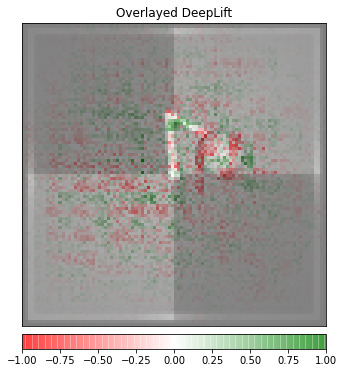

In [98]:
@interp_ex.capture
def deep_lift():
    for img, label in zip(images, labels):
        deep_lift_(network, img, label, original_img, log_dir, False)

deep_lift()

## Layer Conductance
Conductance combines the neuron activation with the partial derivatives of both the neuron with respect to the input and the output with respect to the neuron to build a more complete picture of neuron importance.

In [103]:
@interp_ex.capture
def layer_conductance():
    for img, label in zip(images, labels):
        module = 'encoder'
        idx = 2
        chosen_layer = choose_layer(network, module, idx)
        if verbose:
            print(f"You have chosen {chosen_layer} to show layer conductance")
        layer_conductance_(network, chosen_layer, img, label, log_dir, show_imgs=True, columns=10)

layer_conductance()

You have chosen Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2)) to show layer conductance


/Users/cynthiachen/Documents/Code/il-representations/src/il_representations/algos/encoders.py:76: UserWarning: Input image tensor values have low stddev 0.0006474289111793041 (range [7.121719391989245e-08, 0.003921018447726965]) (stack: runpy.py:193/runpy.py:85/ipykernel_launcher.py:16/application.py:664/kernelapp.py:612/asyncio.py:149/base_events.py:541/base_events.py:1786/events.py:88/ioloop.py:690/ioloop.py:743/gen.py:787/gen.py:748/kernelbase.py:365/gen.py:209/kernelbase.py:268/gen.py:209/kernelbase.py:545/gen.py:209/ipkernel.py:306/zmqshell.py:536/interactiveshell.py:2877/interactiveshell.py:2922/async_helpers.py:68/interactiveshell.py:3146/interactiveshell.py:3337/interactiveshell.py:3417/<ipython-input-103-098622d23a7a>:11/captured_function.py:42/<ipython-input-103-098622d23a7a>:9/interpret.py:197/layer_conductance.py:311/batching.py:164/batching.py:163/gradient.py:491/gradient.py:238/common.py:503/module.py:550/interpret.py:75/module.py:550/policies.py:493/policies.py:511/polic

AssertionError: Target type 1 is not valid.